# 06_Business_Insights_and_Dashboard_Prep

##### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

pd.set_option("display.max_columns", 100)


##### Load Data & Model

In [2]:
df = pd.read_parquet(
    "data/cleaned/yellow_taxi_features_hourly_zone_2025.parquet"
)

model = joblib.load(
    "outputs/models/lightgbm_hourly_zone_demand.pkl"
)

df = df.sort_values("pickup_hour_ts")


##### Generate Predictions (Full Dataset)

In [3]:
FEATURES = [
    c for c in df.columns
    if c not in ["demand", "pickup_hour_ts"]
]

df["predicted_demand"] = model.predict(df[FEATURES])


### PART 1 — Demand Overview (Big Picture)

##### Total Demand by Zone

In [4]:
zone_demand = (
    df
    .groupby("PULocationID")["demand"]
    .sum()
    .sort_values(ascending=False)
)

zone_demand.head(10)


PULocationID
237    1857272
161    1841473
132    1701664
236    1634144
186    1340528
162    1318697
230    1318032
142    1200532
234    1125611
170    1124941
Name: demand, dtype: int64

##### Plot Top 10 Demand Zones

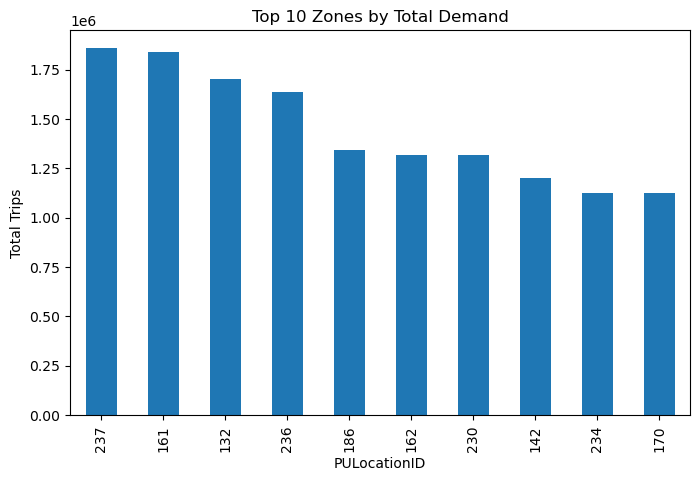

In [5]:
plt.figure(figsize=(8,5))
zone_demand.head(10).plot(kind="bar")
plt.title("Top 10 Zones by Total Demand")
plt.xlabel("PULocationID")
plt.ylabel("Total Trips")
plt.show()


### PART 2 — Peak Hour Analysis

##### Demand by Hour

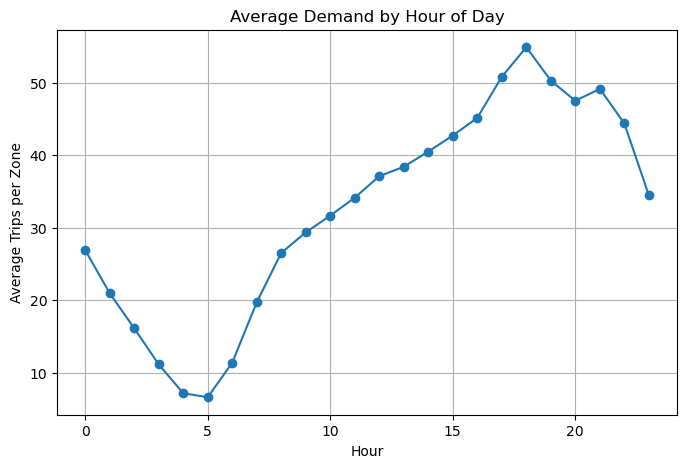

In [6]:
hourly_demand = (
    df
    .groupby("hour")["demand"]
    .mean()
)

plt.figure(figsize=(8,5))
hourly_demand.plot(marker="o")
plt.title("Average Demand by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Average Trips per Zone")
plt.grid(True)
plt.show()


### PART 3 — Zone × Hour Hotspots

##### Highest Demand Zone-Hour Combinations

In [7]:
zone_hour_hotspots = (
    df
    .groupby(["PULocationID", "hour"])["demand"]
    .mean()
    .sort_values(ascending=False)
)

zone_hour_hotspots.head(10)


PULocationID  hour
161           18      493.015015
              17      480.816817
237           15      433.978979
              14      432.360360
161           20      428.000000
              19      427.351351
237           17      423.774775
              18      420.756757
161           21      413.855856
              16      411.186186
Name: demand, dtype: float64

### PART 4 — Weekday vs Weekend Demand

##### Weekday vs Weekend Comparison

In [8]:
weekday_vs_weekend = (
    df
    .groupby("is_weekend")["demand"]
    .mean()
)

weekday_vs_weekend


is_weekend
0    33.605673
1    31.969360
Name: demand, dtype: float64

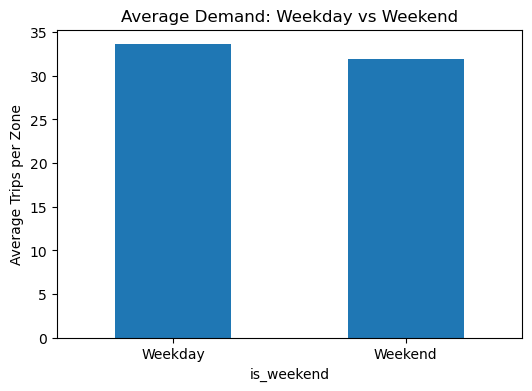

In [9]:
weekday_vs_weekend.plot(kind="bar", figsize=(6,4))
plt.title("Average Demand: Weekday vs Weekend")
plt.xticks([0,1], ["Weekday", "Weekend"], rotation=0)
plt.ylabel("Average Trips per Zone")
plt.show()


### PART 5 — Forecast-based Planning

##### Predicted Demand Peaks

In [10]:
predicted_peaks = (
    df
    .groupby(["PULocationID", "hour"])["predicted_demand"]
    .mean()
    .sort_values(ascending=False)
)

predicted_peaks.head(10)


PULocationID  hour
161           18      492.287242
              17      474.837051
237           15      438.167349
161           19      428.867098
              20      425.379778
237           14      425.150168
              17      424.380652
              18      421.409619
161           21      413.544556
              16      407.801306
Name: predicted_demand, dtype: float64

### PART 6 — Business Recommendations

1. **Prioritize High-Demand Zones**
   - A small subset of zones consistently accounts for the majority of demand.
   - These zones should receive priority in fleet allocation and driver incentives.

2. **Increase Supply During Peak Hours**
   - Demand peaks occur during morning (7–9 AM) and evening (5–9 PM) hours.
   - Dynamic scheduling can reduce unmet demand during these periods.

3. **Special Handling for Volatile Zones**
   - Zones with high prediction error (e.g., airports and transit hubs) require additional signals such as weather or event data.

4. **Weekend-Specific Strategies**
   - Weekend demand patterns differ from weekdays.
   - Adaptive pricing or staffing strategies may improve service levels.

5. **Use Forecasts for Proactive Planning**
   - Hourly zone-level forecasts enable proactive positioning of vehicles rather than reactive dispatching.


##### Save Dashboard-Ready Outputs

In [13]:
# Save top demand zones
zone_demand.to_csv(
    "outputs/dashboard/top_zones_by_demand.csv"
)

# Save hourly demand pattern
hourly_demand.to_csv(
    "outputs/dashboard/hourly_demand_pattern.csv"
)

# Save zone-hour hotspots
zone_hour_hotspots.head(100).to_csv(
    "outputs/dashboard/zone_hour_hotspots.csv"
)
